# Low-Rank Approximation Fine-Tuning

This notebook demonstrates encrypted fine-tuning of a small MLP model with LoRA. A model trained on an initial dataset is adapted to a second dataset using LoRA fine-tuning.

The fine-tuning dataset and the trained LoRA weights are protected using encryption. Thus, training can be securely outsourced to a remote server without compromising any sensitive data.

The hybrid approach is applied to fine-tuning: only the linear layers of the original model are outsourced to the server. The forward and backward passes on these layers are performed using encrypted activations and gradients. Meanwhile, the LoRA weights are kept by the client, which performs locally the forward and backward passes on the LoRA weights.

In [1]:
import shutil
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from peft import LoraConfig, get_peft_model
from sklearn.datasets import make_circles, make_moons
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset

from concrete.ml.torch.lora import LoraTrainer

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED);

## Data preparation

Two datasets are generated: one for the original training, and a second one on which LoRA fine-tuning is performed.

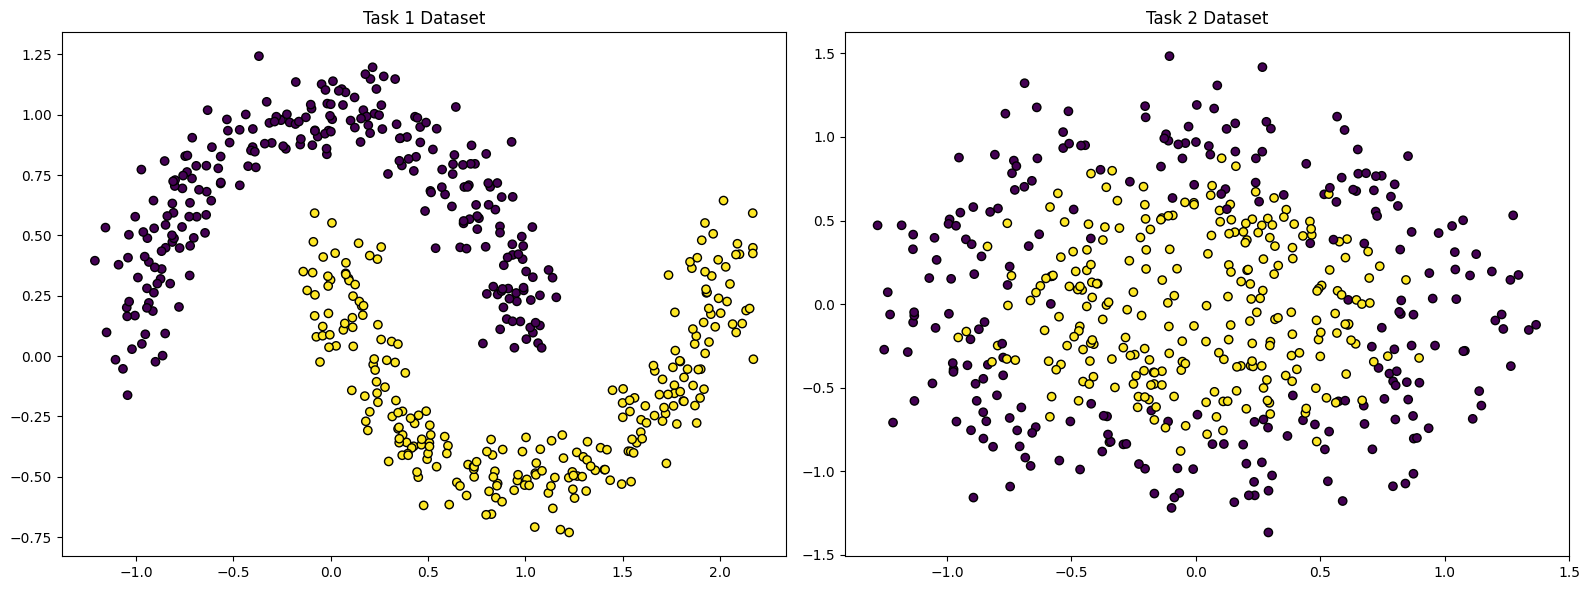

In [2]:
# Task 1: Two interleaving half circles
X_task1, y_task1 = make_moons(n_samples=500, noise=0.1)
# Task 2: Two concentric circles
X_task2, y_task2 = make_circles(n_samples=500, noise=0.2, factor=0.5)


def plot_datasets_and_boundaries(X_task1, y_task1, X_task2, y_task2, model=None, titles=None):
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    if titles is None:
        titles = ["Task 1 Dataset", "Task 2 Dataset"]

    for ax, X, y, title in zip([ax1, ax2], [X_task1, X_task2], [y_task1, y_task2], titles):
        ax.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis", edgecolor="k")
        ax.set_title(title)

        if model is not None:
            x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
            y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
            h = 0.1  # step size in the mesh
            xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
            grid = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])

            with torch.no_grad():
                Z = model(grid)
                probabilities = torch.softmax(Z, dim=1)
                Z = probabilities[:, 1].numpy().reshape(xx.shape)

            ax.contourf(xx, yy, Z, cmap="viridis", alpha=0.3)

    plt.tight_layout()
    plt.show()


# Plot datasets
plot_datasets_and_boundaries(X_task1, y_task1, X_task2, y_task2)

## Create the original MLP and test it

Training on Task 1 without LoRA:


Epoch [20/20], Loss: 0.0036


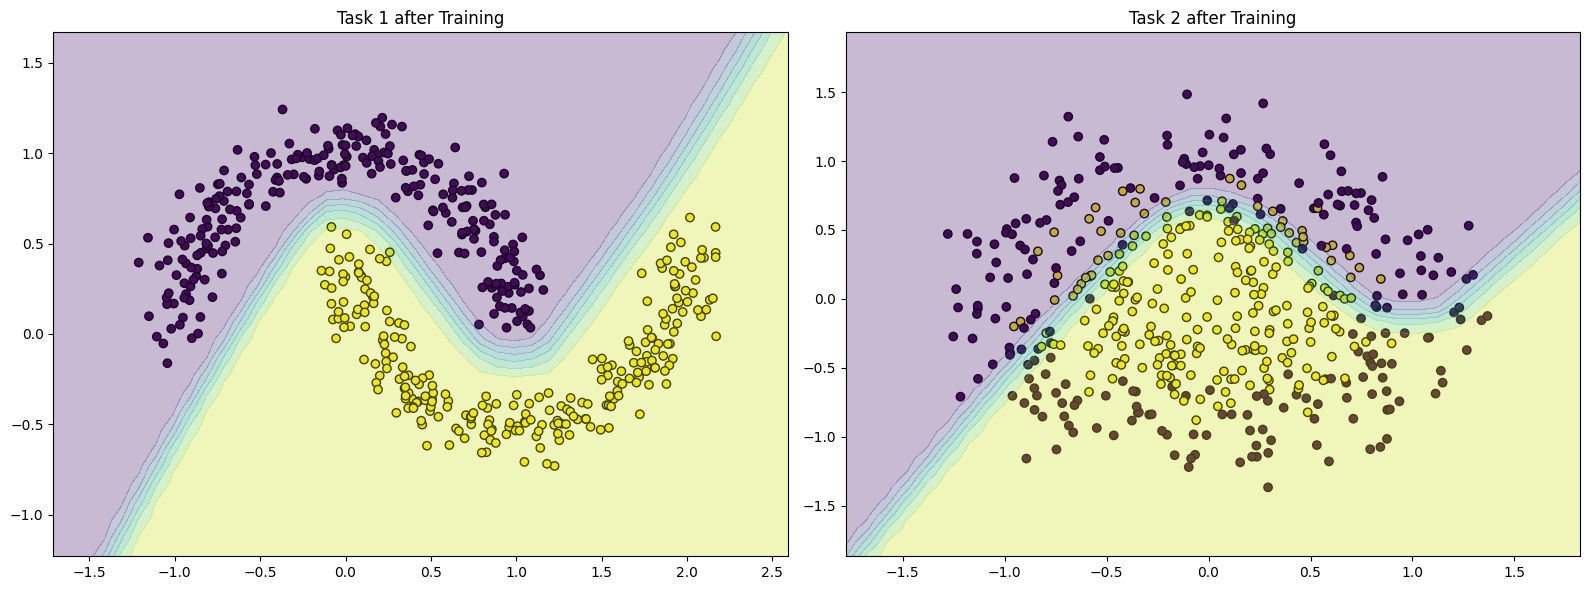

In [3]:
# Convert datasets to PyTorch tensors
X_task1 = torch.FloatTensor(X_task1)
y_task1 = torch.LongTensor(y_task1)
X_task2 = torch.FloatTensor(X_task2)
y_task2 = torch.LongTensor(y_task2)

# Create DataLoaders
batch_size = 32
train_loader_task1 = DataLoader(
    TensorDataset(X_task1, y_task1), batch_size=batch_size, shuffle=True
)
train_loader_task2 = DataLoader(
    TensorDataset(X_task2, y_task2), batch_size=batch_size, shuffle=True
)

# Define an MLP model without LoRA layers


class SimpleMLP(nn.Module):
    """Simple MLP model without LoRA layers."""

    def __init__(self, input_size=2, hidden_size=128, num_classes=2):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x, labels=None):  # pylint: disable=unused-argument
        """Forward pass of the MLP."""
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out


# Instantiate the model
model = SimpleMLP()

# Training loop for Task 1


def train_model(model, train_loader, num_epochs=100):
    """Train the model.

    Args:
        model (nn.Module): The model to train.
        train_loader (DataLoader): DataLoader for training data.
        num_epochs (int): Number of epochs to train.
    """
    device = torch.device("cpu")
    model.to(device)
    model.train()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(num_epochs):
        total_loss = 0
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Print loss every 20 epochs
        if (epoch + 1) % 20 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")


# Train the model on Task 1
print("Training on Task 1 without LoRA:")
train_model(model, train_loader_task1, num_epochs=20)

# Plot datasets with decision boundaries
plot_datasets_and_boundaries(
    X_task1.numpy(),
    y_task1.numpy(),
    X_task2.numpy(),
    y_task2.numpy(),
    model=model,
    titles=["Task 1 after Training", "Task 2 after Training"],
)

## Apply LoRA to the model using peft

In [4]:
# Apply LoRA to the model using peft
lora_config = LoraConfig(
    r=1, lora_alpha=1, lora_dropout=0.01, target_modules=["fc1", "fc2"], bias="none"
)

peft_model = get_peft_model(model, lora_config)

## Setup FHE fine-tuning with LoraTrainer

In [5]:
# Update training parameters, including loss function
optimizer = optim.Adam(filter(lambda p: p.requires_grad, peft_model.parameters()), lr=0.01)
loss_fn = nn.CrossEntropyLoss()
training_args = {"gradient_accumulation_steps": 1}

# Set up LoRA training
lora_trainer = LoraTrainer(
    peft_model, optimizer=optimizer, loss_fn=loss_fn, training_args=training_args
)

# Prepare input data for calibration
batch_size_per_task = batch_size // 2
inputset = (
    torch.cat([X_task1[:batch_size_per_task], X_task2[:batch_size_per_task]]),
    torch.cat([y_task1[:batch_size_per_task], y_task2[:batch_size_per_task]]),
)

# Compile the model
lora_trainer.compile(inputset, n_bits=8)

2025-02-28 12:10:03,770 - INFO - === Starting new training session ===


LoRA layers detected in the model.


Compiling FHE layers:   0%|          | 0/3 [00:00<?, ?it/s]

2025-02-28 12:10:04,083 - INFO - Compilation complete.


(0, 0)

In [6]:
# Fine-tune the model on Task 2 using LoRA
lora_trainer.train(train_loader_task2, num_epochs=10, fhe="execute")

Epoch 1:   0%|          | 0/16 [00:00<?, ?it/s]

2025-02-28 12:10:06,325 - INFO - Step 1: loss=2.983021, avg_loss=2.983021


2025-02-28 12:10:06,327 - INFO - Average gradient magnitude: 0.045490


2025-02-28 12:10:08,420 - INFO - Step 2: loss=2.714796, avg_loss=2.848909


2025-02-28 12:10:08,421 - INFO - Average gradient magnitude: 0.055881


2025-02-28 12:10:10,449 - INFO - Step 3: loss=3.400520, avg_loss=3.032779


2025-02-28 12:10:10,450 - INFO - Average gradient magnitude: 0.116559


2025-02-28 12:10:12,575 - INFO - Step 4: loss=3.154915, avg_loss=3.063313


2025-02-28 12:10:12,577 - INFO - Average gradient magnitude: 0.129288


2025-02-28 12:10:14,743 - INFO - Step 5: loss=2.374048, avg_loss=2.925460


2025-02-28 12:10:14,745 - INFO - Average gradient magnitude: 0.102270


2025-02-28 12:10:16,907 - INFO - Step 6: loss=1.399900, avg_loss=2.671200


2025-02-28 12:10:16,908 - INFO - Average gradient magnitude: 0.137591


2025-02-28 12:10:19,012 - INFO - Step 7: loss=2.299220, avg_loss=2.618060


2025-02-28 12:10:19,014 - INFO - Average gradient magnitude: 0.122903


2025-02-28 12:10:21,067 - INFO - Step 8: loss=3.874964, avg_loss=2.775173


2025-02-28 12:10:21,068 - INFO - Average gradient magnitude: 0.248744


2025-02-28 12:10:23,143 - INFO - Step 9: loss=2.879501, avg_loss=2.786765


2025-02-28 12:10:23,144 - INFO - Average gradient magnitude: 0.154390


2025-02-28 12:10:25,220 - INFO - Step 10: loss=2.658129, avg_loss=2.773901


2025-02-28 12:10:25,221 - INFO - No evaluation data or metric function provided.


2025-02-28 12:10:25,222 - INFO - Average gradient magnitude: 0.240021


2025-02-28 12:10:27,273 - INFO - Step 11: loss=1.402351, avg_loss=2.649215


2025-02-28 12:10:27,275 - INFO - Average gradient magnitude: 0.132233


2025-02-28 12:10:29,348 - INFO - Step 12: loss=2.013147, avg_loss=2.596209


2025-02-28 12:10:29,349 - INFO - Average gradient magnitude: 0.196361


2025-02-28 12:10:31,403 - INFO - Step 13: loss=3.256433, avg_loss=2.646996


2025-02-28 12:10:31,404 - INFO - Average gradient magnitude: 0.276839


2025-02-28 12:10:33,652 - INFO - Step 14: loss=1.359903, avg_loss=2.555061


2025-02-28 12:10:33,658 - INFO - Average gradient magnitude: 0.130106


2025-02-28 12:10:35,715 - INFO - Step 15: loss=1.240777, avg_loss=2.467442


2025-02-28 12:10:35,716 - INFO - Average gradient magnitude: 0.232516


2025-02-28 12:10:37,060 - INFO - Step 16: loss=1.205164, avg_loss=2.388549


2025-02-28 12:10:37,062 - INFO - Average gradient magnitude: 0.213272


2025-02-28 12:10:37,066 - INFO - Epoch 1 completed. Avg Loss: 2.388549, FHE Mode: execute


Epoch 2:   0%|          | 0/16 [00:00<?, ?it/s]

2025-02-28 12:10:39,117 - INFO - Step 17: loss=1.888700, avg_loss=1.888700


2025-02-28 12:10:39,121 - INFO - Average gradient magnitude: 0.388105


2025-02-28 12:10:41,181 - INFO - Step 18: loss=2.237790, avg_loss=2.063245


2025-02-28 12:10:41,183 - INFO - Average gradient magnitude: 0.309982


2025-02-28 12:10:43,287 - INFO - Step 19: loss=1.299806, avg_loss=1.808765


2025-02-28 12:10:43,289 - INFO - Average gradient magnitude: 0.183158


2025-02-28 12:10:45,330 - INFO - Step 20: loss=1.781332, avg_loss=1.801907


2025-02-28 12:10:45,331 - INFO - No evaluation data or metric function provided.


2025-02-28 12:10:45,332 - INFO - Average gradient magnitude: 0.264557


2025-02-28 12:10:47,361 - INFO - Step 21: loss=1.126707, avg_loss=1.666867


2025-02-28 12:10:47,362 - INFO - Average gradient magnitude: 0.238591


2025-02-28 12:10:49,403 - INFO - Step 22: loss=1.725626, avg_loss=1.676660


2025-02-28 12:10:49,404 - INFO - Average gradient magnitude: 0.280338


2025-02-28 12:10:51,350 - INFO - Step 23: loss=1.817029, avg_loss=1.696713


2025-02-28 12:10:51,351 - INFO - Average gradient magnitude: 0.303914


2025-02-28 12:10:53,363 - INFO - Step 24: loss=1.698468, avg_loss=1.696932


2025-02-28 12:10:53,364 - INFO - Average gradient magnitude: 0.370472


2025-02-28 12:10:55,381 - INFO - Step 25: loss=1.034375, avg_loss=1.623315


2025-02-28 12:10:55,382 - INFO - Average gradient magnitude: 0.156739


2025-02-28 12:10:57,363 - INFO - Step 26: loss=1.827242, avg_loss=1.643708


2025-02-28 12:10:57,364 - INFO - Average gradient magnitude: 0.422594


2025-02-28 12:10:59,501 - INFO - Step 27: loss=0.740353, avg_loss=1.561584


2025-02-28 12:10:59,503 - INFO - Average gradient magnitude: 0.164675


2025-02-28 12:11:01,699 - INFO - Step 28: loss=1.402921, avg_loss=1.548362


2025-02-28 12:11:01,701 - INFO - Average gradient magnitude: 0.400768


2025-02-28 12:11:04,173 - INFO - Step 29: loss=1.802701, avg_loss=1.567927


2025-02-28 12:11:04,175 - INFO - Average gradient magnitude: 0.484718


2025-02-28 12:11:06,205 - INFO - Step 30: loss=2.246274, avg_loss=1.616380


2025-02-28 12:11:06,206 - INFO - No evaluation data or metric function provided.


2025-02-28 12:11:06,207 - INFO - Average gradient magnitude: 0.669566


2025-02-28 12:11:08,278 - INFO - Step 31: loss=1.792768, avg_loss=1.628140


2025-02-28 12:11:08,280 - INFO - Average gradient magnitude: 0.485152


2025-02-28 12:11:09,666 - INFO - Step 32: loss=0.582126, avg_loss=1.562764


2025-02-28 12:11:09,669 - INFO - Average gradient magnitude: 0.118186


2025-02-28 12:11:09,672 - INFO - Epoch 2 completed. Avg Loss: 1.562764, FHE Mode: execute


Epoch 3:   0%|          | 0/16 [00:00<?, ?it/s]

2025-02-28 12:11:11,701 - INFO - Step 33: loss=1.699811, avg_loss=1.699811


2025-02-28 12:11:11,704 - INFO - Average gradient magnitude: 0.395175


2025-02-28 12:11:13,738 - INFO - Step 34: loss=0.850926, avg_loss=1.275368


2025-02-28 12:11:13,740 - INFO - Average gradient magnitude: 0.314470


2025-02-28 12:11:15,843 - INFO - Step 35: loss=0.591825, avg_loss=1.047520


2025-02-28 12:11:15,845 - INFO - Average gradient magnitude: 0.105794


2025-02-28 12:11:17,860 - INFO - Step 36: loss=1.435197, avg_loss=1.144439


2025-02-28 12:11:17,862 - INFO - Average gradient magnitude: 0.394996


2025-02-28 12:11:19,893 - INFO - Step 37: loss=0.517340, avg_loss=1.019020


2025-02-28 12:11:19,895 - INFO - Average gradient magnitude: 0.175848


2025-02-28 12:11:21,923 - INFO - Step 38: loss=1.053009, avg_loss=1.024684


2025-02-28 12:11:21,924 - INFO - Average gradient magnitude: 0.287324


2025-02-28 12:11:23,908 - INFO - Step 39: loss=0.526010, avg_loss=0.953445


2025-02-28 12:11:23,910 - INFO - Average gradient magnitude: 0.099519


2025-02-28 12:11:25,937 - INFO - Step 40: loss=0.601653, avg_loss=0.909471


2025-02-28 12:11:25,939 - INFO - No evaluation data or metric function provided.


2025-02-28 12:11:25,940 - INFO - Average gradient magnitude: 0.172541


2025-02-28 12:11:27,969 - INFO - Step 41: loss=1.506674, avg_loss=0.975827


2025-02-28 12:11:27,972 - INFO - Average gradient magnitude: 0.669648


2025-02-28 12:11:30,023 - INFO - Step 42: loss=0.981908, avg_loss=0.976435


2025-02-28 12:11:30,024 - INFO - Average gradient magnitude: 0.325719


2025-02-28 12:11:32,067 - INFO - Step 43: loss=0.329335, avg_loss=0.917608


2025-02-28 12:11:32,069 - INFO - Average gradient magnitude: 0.098826


2025-02-28 12:11:34,136 - INFO - Step 44: loss=0.901595, avg_loss=0.916273


2025-02-28 12:11:34,138 - INFO - Average gradient magnitude: 0.188251


2025-02-28 12:11:36,282 - INFO - Step 45: loss=0.742387, avg_loss=0.902898


2025-02-28 12:11:36,283 - INFO - Average gradient magnitude: 0.272826


2025-02-28 12:11:38,349 - INFO - Step 46: loss=0.415526, avg_loss=0.868085


2025-02-28 12:11:38,350 - INFO - Average gradient magnitude: 0.170158


2025-02-28 12:11:40,427 - INFO - Step 47: loss=0.304636, avg_loss=0.830522


2025-02-28 12:11:40,429 - INFO - Average gradient magnitude: 0.126754


2025-02-28 12:11:41,746 - INFO - Step 48: loss=0.587809, avg_loss=0.815352


2025-02-28 12:11:41,747 - INFO - Average gradient magnitude: 0.202007


2025-02-28 12:11:41,751 - INFO - Epoch 3 completed. Avg Loss: 0.815352, FHE Mode: execute


Epoch 4:   0%|          | 0/16 [00:00<?, ?it/s]

2025-02-28 12:11:43,911 - INFO - Step 49: loss=0.454426, avg_loss=0.454426


2025-02-28 12:11:43,913 - INFO - Average gradient magnitude: 0.241879


2025-02-28 12:11:46,083 - INFO - Step 50: loss=0.178918, avg_loss=0.316672


2025-02-28 12:11:46,084 - INFO - No evaluation data or metric function provided.


2025-02-28 12:11:46,086 - INFO - Average gradient magnitude: 0.104298


2025-02-28 12:11:48,041 - INFO - Step 51: loss=0.393130, avg_loss=0.342158


2025-02-28 12:11:48,042 - INFO - Average gradient magnitude: 0.157900


2025-02-28 12:11:49,999 - INFO - Step 52: loss=0.627492, avg_loss=0.413491


2025-02-28 12:11:50,002 - INFO - Average gradient magnitude: 0.182522


2025-02-28 12:11:51,968 - INFO - Step 53: loss=0.571932, avg_loss=0.445180


2025-02-28 12:11:51,971 - INFO - Average gradient magnitude: 0.128057


2025-02-28 12:11:53,940 - INFO - Step 54: loss=0.840344, avg_loss=0.511040


2025-02-28 12:11:53,942 - INFO - Average gradient magnitude: 0.204602


2025-02-28 12:11:55,964 - INFO - Step 55: loss=0.391592, avg_loss=0.493976


2025-02-28 12:11:55,966 - INFO - Average gradient magnitude: 0.351909


2025-02-28 12:11:57,991 - INFO - Step 56: loss=0.474403, avg_loss=0.491530


2025-02-28 12:11:57,992 - INFO - Average gradient magnitude: 0.295082


2025-02-28 12:12:00,011 - INFO - Step 57: loss=0.583520, avg_loss=0.501751


2025-02-28 12:12:00,014 - INFO - Average gradient magnitude: 0.228412


2025-02-28 12:12:02,005 - INFO - Step 58: loss=0.696179, avg_loss=0.521194


2025-02-28 12:12:02,007 - INFO - Average gradient magnitude: 0.309479


2025-02-28 12:12:04,009 - INFO - Step 59: loss=0.415805, avg_loss=0.511613


2025-02-28 12:12:04,010 - INFO - Average gradient magnitude: 0.120802


2025-02-28 12:12:06,060 - INFO - Step 60: loss=0.384411, avg_loss=0.501013


2025-02-28 12:12:06,061 - INFO - No evaluation data or metric function provided.


2025-02-28 12:12:06,062 - INFO - Average gradient magnitude: 0.094549


2025-02-28 12:12:08,280 - INFO - Step 61: loss=0.768431, avg_loss=0.521583


2025-02-28 12:12:08,281 - INFO - Average gradient magnitude: 0.359421


2025-02-28 12:12:10,346 - INFO - Step 62: loss=0.669465, avg_loss=0.532146


2025-02-28 12:12:10,348 - INFO - Average gradient magnitude: 0.623846


2025-02-28 12:12:12,477 - INFO - Step 63: loss=0.611499, avg_loss=0.537437


2025-02-28 12:12:12,478 - INFO - Average gradient magnitude: 0.272200


2025-02-28 12:12:13,865 - INFO - Step 64: loss=0.221662, avg_loss=0.517701


2025-02-28 12:12:13,866 - INFO - Average gradient magnitude: 0.091699


2025-02-28 12:12:13,870 - INFO - Epoch 4 completed. Avg Loss: 0.517701, FHE Mode: execute


Epoch 5:   0%|          | 0/16 [00:00<?, ?it/s]

2025-02-28 12:12:15,876 - INFO - Step 65: loss=0.545383, avg_loss=0.545383


2025-02-28 12:12:15,877 - INFO - Average gradient magnitude: 0.354444


2025-02-28 12:12:17,892 - INFO - Step 66: loss=0.312895, avg_loss=0.429139


2025-02-28 12:12:17,894 - INFO - Average gradient magnitude: 0.086229


2025-02-28 12:12:20,000 - INFO - Step 67: loss=0.287882, avg_loss=0.382053


2025-02-28 12:12:20,002 - INFO - Average gradient magnitude: 0.174430


2025-02-28 12:12:22,092 - INFO - Step 68: loss=0.588943, avg_loss=0.433776


2025-02-28 12:12:22,093 - INFO - Average gradient magnitude: 0.171962


2025-02-28 12:12:24,197 - INFO - Step 69: loss=0.440805, avg_loss=0.435182


2025-02-28 12:12:24,199 - INFO - Average gradient magnitude: 0.135506


2025-02-28 12:12:26,223 - INFO - Step 70: loss=0.966590, avg_loss=0.523750


2025-02-28 12:12:26,224 - INFO - No evaluation data or metric function provided.


2025-02-28 12:12:26,225 - INFO - Average gradient magnitude: 0.329220


2025-02-28 12:12:28,321 - INFO - Step 71: loss=0.493836, avg_loss=0.519476


2025-02-28 12:12:28,323 - INFO - Average gradient magnitude: 0.170424


2025-02-28 12:12:30,412 - INFO - Step 72: loss=0.452875, avg_loss=0.511151


2025-02-28 12:12:30,414 - INFO - Average gradient magnitude: 0.101867


2025-02-28 12:12:32,532 - INFO - Step 73: loss=0.384745, avg_loss=0.497106


2025-02-28 12:12:32,534 - INFO - Average gradient magnitude: 0.217848


2025-02-28 12:12:34,598 - INFO - Step 74: loss=0.440801, avg_loss=0.491475


2025-02-28 12:12:34,600 - INFO - Average gradient magnitude: 0.215943


2025-02-28 12:12:36,634 - INFO - Step 75: loss=0.309629, avg_loss=0.474944


2025-02-28 12:12:36,636 - INFO - Average gradient magnitude: 0.071840


2025-02-28 12:12:38,682 - INFO - Step 76: loss=0.308688, avg_loss=0.461089


2025-02-28 12:12:38,684 - INFO - Average gradient magnitude: 0.108904


2025-02-28 12:12:40,646 - INFO - Step 77: loss=0.169218, avg_loss=0.438638


2025-02-28 12:12:40,648 - INFO - Average gradient magnitude: 0.052192


2025-02-28 12:12:42,642 - INFO - Step 78: loss=0.228031, avg_loss=0.423594


2025-02-28 12:12:42,643 - INFO - Average gradient magnitude: 0.143392


2025-02-28 12:12:44,625 - INFO - Step 79: loss=0.235620, avg_loss=0.411063


2025-02-28 12:12:44,626 - INFO - Average gradient magnitude: 0.127110


2025-02-28 12:12:45,876 - INFO - Step 80: loss=0.355380, avg_loss=0.407583


2025-02-28 12:12:45,877 - INFO - No evaluation data or metric function provided.


2025-02-28 12:12:45,878 - INFO - Average gradient magnitude: 0.245862


2025-02-28 12:12:45,881 - INFO - Epoch 5 completed. Avg Loss: 0.407583, FHE Mode: execute


Epoch 6:   0%|          | 0/16 [00:00<?, ?it/s]

2025-02-28 12:12:47,894 - INFO - Step 81: loss=0.187420, avg_loss=0.187420


2025-02-28 12:12:47,895 - INFO - Average gradient magnitude: 0.158001


2025-02-28 12:12:49,915 - INFO - Step 82: loss=0.328243, avg_loss=0.257831


2025-02-28 12:12:49,917 - INFO - Average gradient magnitude: 0.099908


2025-02-28 12:12:51,948 - INFO - Step 83: loss=0.401144, avg_loss=0.305602


2025-02-28 12:12:51,949 - INFO - Average gradient magnitude: 0.137346


2025-02-28 12:12:53,981 - INFO - Step 84: loss=0.444166, avg_loss=0.340243


2025-02-28 12:12:53,983 - INFO - Average gradient magnitude: 0.078070


2025-02-28 12:12:56,016 - INFO - Step 85: loss=0.163632, avg_loss=0.304921


2025-02-28 12:12:56,018 - INFO - Average gradient magnitude: 0.078310


2025-02-28 12:12:58,048 - INFO - Step 86: loss=0.494887, avg_loss=0.336582


2025-02-28 12:12:58,049 - INFO - Average gradient magnitude: 0.354065


2025-02-28 12:13:00,088 - INFO - Step 87: loss=0.353141, avg_loss=0.338947


2025-02-28 12:13:00,089 - INFO - Average gradient magnitude: 0.202816


2025-02-28 12:13:02,069 - INFO - Step 88: loss=0.281555, avg_loss=0.331773


2025-02-28 12:13:02,071 - INFO - Average gradient magnitude: 0.167217


2025-02-28 12:13:04,059 - INFO - Step 89: loss=0.232591, avg_loss=0.320753


2025-02-28 12:13:04,061 - INFO - Average gradient magnitude: 0.087037


2025-02-28 12:13:06,105 - INFO - Step 90: loss=0.352010, avg_loss=0.323879


2025-02-28 12:13:06,107 - INFO - No evaluation data or metric function provided.


2025-02-28 12:13:06,109 - INFO - Average gradient magnitude: 0.072653


2025-02-28 12:13:08,165 - INFO - Step 91: loss=0.491103, avg_loss=0.339081


2025-02-28 12:13:08,166 - INFO - Average gradient magnitude: 0.202845


2025-02-28 12:13:10,184 - INFO - Step 92: loss=0.386000, avg_loss=0.342991


2025-02-28 12:13:10,186 - INFO - Average gradient magnitude: 0.127644


2025-02-28 12:13:12,183 - INFO - Step 93: loss=0.131703, avg_loss=0.326738


2025-02-28 12:13:12,184 - INFO - Average gradient magnitude: 0.086134


2025-02-28 12:13:14,255 - INFO - Step 94: loss=0.432376, avg_loss=0.334284


2025-02-28 12:13:14,258 - INFO - Average gradient magnitude: 0.152512


2025-02-28 12:13:16,330 - INFO - Step 95: loss=0.396905, avg_loss=0.338458


2025-02-28 12:13:16,332 - INFO - Average gradient magnitude: 0.094189


2025-02-28 12:13:17,682 - INFO - Step 96: loss=0.306745, avg_loss=0.336476


2025-02-28 12:13:17,684 - INFO - Average gradient magnitude: 0.211290


2025-02-28 12:13:17,688 - INFO - Epoch 6 completed. Avg Loss: 0.336476, FHE Mode: execute


Epoch 7:   0%|          | 0/16 [00:00<?, ?it/s]

2025-02-28 12:13:19,781 - INFO - Step 97: loss=0.258877, avg_loss=0.258877


2025-02-28 12:13:19,782 - INFO - Average gradient magnitude: 0.135518


2025-02-28 12:13:21,797 - INFO - Step 98: loss=0.476487, avg_loss=0.367682


2025-02-28 12:13:21,798 - INFO - Average gradient magnitude: 0.103264


2025-02-28 12:13:23,880 - INFO - Step 99: loss=0.332024, avg_loss=0.355796


2025-02-28 12:13:23,881 - INFO - Average gradient magnitude: 0.126608


2025-02-28 12:13:25,951 - INFO - Step 100: loss=0.281371, avg_loss=0.337189


2025-02-28 12:13:25,953 - INFO - No evaluation data or metric function provided.


2025-02-28 12:13:25,954 - INFO - Average gradient magnitude: 0.131448


2025-02-28 12:13:27,989 - INFO - Step 101: loss=0.406451, avg_loss=0.351042


2025-02-28 12:13:27,991 - INFO - Average gradient magnitude: 0.137471


2025-02-28 12:13:30,015 - INFO - Step 102: loss=0.240500, avg_loss=0.332618


2025-02-28 12:13:30,017 - INFO - Average gradient magnitude: 0.100274


2025-02-28 12:13:32,056 - INFO - Step 103: loss=0.244441, avg_loss=0.320021


2025-02-28 12:13:32,058 - INFO - Average gradient magnitude: 0.098634


2025-02-28 12:13:34,146 - INFO - Step 104: loss=0.336056, avg_loss=0.322026


2025-02-28 12:13:34,148 - INFO - Average gradient magnitude: 0.262308


2025-02-28 12:13:36,262 - INFO - Step 105: loss=0.139490, avg_loss=0.301744


2025-02-28 12:13:36,263 - INFO - Average gradient magnitude: 0.096513


2025-02-28 12:13:38,338 - INFO - Step 106: loss=0.478837, avg_loss=0.319453


2025-02-28 12:13:38,340 - INFO - Average gradient magnitude: 0.176876


2025-02-28 12:13:40,416 - INFO - Step 107: loss=0.376467, avg_loss=0.324636


2025-02-28 12:13:40,418 - INFO - Average gradient magnitude: 0.222902


2025-02-28 12:13:42,452 - INFO - Step 108: loss=0.309930, avg_loss=0.323411


2025-02-28 12:13:42,453 - INFO - Average gradient magnitude: 0.238708


2025-02-28 12:13:44,421 - INFO - Step 109: loss=0.256039, avg_loss=0.318228


2025-02-28 12:13:44,423 - INFO - Average gradient magnitude: 0.152556


2025-02-28 12:13:46,448 - INFO - Step 110: loss=0.364201, avg_loss=0.321512


2025-02-28 12:13:46,449 - INFO - No evaluation data or metric function provided.


2025-02-28 12:13:46,450 - INFO - Average gradient magnitude: 0.102538


2025-02-28 12:13:48,492 - INFO - Step 111: loss=0.207409, avg_loss=0.313905


2025-02-28 12:13:48,493 - INFO - Average gradient magnitude: 0.136450


2025-02-28 12:13:49,856 - INFO - Step 112: loss=0.150604, avg_loss=0.303699


2025-02-28 12:13:49,857 - INFO - Average gradient magnitude: 0.167597


2025-02-28 12:13:49,862 - INFO - Epoch 7 completed. Avg Loss: 0.303699, FHE Mode: execute


Epoch 8:   0%|          | 0/16 [00:00<?, ?it/s]

2025-02-28 12:13:51,933 - INFO - Step 113: loss=0.330405, avg_loss=0.330405


2025-02-28 12:13:51,935 - INFO - Average gradient magnitude: 0.050067


2025-02-28 12:13:53,959 - INFO - Step 114: loss=0.236064, avg_loss=0.283234


2025-02-28 12:13:53,961 - INFO - Average gradient magnitude: 0.089857


2025-02-28 12:13:55,989 - INFO - Step 115: loss=0.157938, avg_loss=0.241469


2025-02-28 12:13:55,991 - INFO - Average gradient magnitude: 0.091045


2025-02-28 12:13:58,010 - INFO - Step 116: loss=0.364117, avg_loss=0.272131


2025-02-28 12:13:58,012 - INFO - Average gradient magnitude: 0.145151


2025-02-28 12:14:00,118 - INFO - Step 117: loss=0.284289, avg_loss=0.274563


2025-02-28 12:14:00,119 - INFO - Average gradient magnitude: 0.184201


2025-02-28 12:14:02,228 - INFO - Step 118: loss=0.418892, avg_loss=0.298617


2025-02-28 12:14:02,230 - INFO - Average gradient magnitude: 0.099788


2025-02-28 12:14:04,366 - INFO - Step 119: loss=0.211775, avg_loss=0.286211


2025-02-28 12:14:04,368 - INFO - Average gradient magnitude: 0.109497


2025-02-28 12:14:06,450 - INFO - Step 120: loss=0.325475, avg_loss=0.291119


2025-02-28 12:14:06,451 - INFO - No evaluation data or metric function provided.


2025-02-28 12:14:06,452 - INFO - Average gradient magnitude: 0.099255


2025-02-28 12:14:08,502 - INFO - Step 121: loss=0.220695, avg_loss=0.283294


2025-02-28 12:14:08,503 - INFO - Average gradient magnitude: 0.041139


2025-02-28 12:14:10,566 - INFO - Step 122: loss=0.514257, avg_loss=0.306391


2025-02-28 12:14:10,568 - INFO - Average gradient magnitude: 0.380365


2025-02-28 12:14:12,637 - INFO - Step 123: loss=0.310765, avg_loss=0.306788


2025-02-28 12:14:12,638 - INFO - Average gradient magnitude: 0.228523


2025-02-28 12:14:14,696 - INFO - Step 124: loss=0.266884, avg_loss=0.303463


2025-02-28 12:14:14,698 - INFO - Average gradient magnitude: 0.218310


2025-02-28 12:14:16,738 - INFO - Step 125: loss=0.178938, avg_loss=0.293884


2025-02-28 12:14:16,739 - INFO - Average gradient magnitude: 0.086000


2025-02-28 12:14:18,782 - INFO - Step 126: loss=0.219860, avg_loss=0.288597


2025-02-28 12:14:18,783 - INFO - Average gradient magnitude: 0.083966


2025-02-28 12:14:20,824 - INFO - Step 127: loss=0.275913, avg_loss=0.287751


2025-02-28 12:14:20,826 - INFO - Average gradient magnitude: 0.163537


2025-02-28 12:14:22,160 - INFO - Step 128: loss=0.259478, avg_loss=0.285984


2025-02-28 12:14:22,162 - INFO - Average gradient magnitude: 0.190798


2025-02-28 12:14:22,166 - INFO - Epoch 8 completed. Avg Loss: 0.285984, FHE Mode: execute


Epoch 9:   0%|          | 0/16 [00:00<?, ?it/s]

2025-02-28 12:14:24,220 - INFO - Step 129: loss=0.283839, avg_loss=0.283839


2025-02-28 12:14:24,222 - INFO - Average gradient magnitude: 0.224923


2025-02-28 12:14:26,198 - INFO - Step 130: loss=0.286148, avg_loss=0.284993


2025-02-28 12:14:26,200 - INFO - No evaluation data or metric function provided.


2025-02-28 12:14:26,201 - INFO - Average gradient magnitude: 0.244166


2025-02-28 12:14:28,249 - INFO - Step 131: loss=0.408748, avg_loss=0.326245


2025-02-28 12:14:28,250 - INFO - Average gradient magnitude: 0.149906


2025-02-28 12:14:30,374 - INFO - Step 132: loss=0.314403, avg_loss=0.323284


2025-02-28 12:14:30,376 - INFO - Average gradient magnitude: 0.223743


2025-02-28 12:14:32,448 - INFO - Step 133: loss=0.371280, avg_loss=0.332883


2025-02-28 12:14:32,450 - INFO - Average gradient magnitude: 0.091566


2025-02-28 12:14:34,561 - INFO - Step 134: loss=0.267737, avg_loss=0.322026


2025-02-28 12:14:34,563 - INFO - Average gradient magnitude: 0.121302


2025-02-28 12:14:36,651 - INFO - Step 135: loss=0.162778, avg_loss=0.299276


2025-02-28 12:14:36,653 - INFO - Average gradient magnitude: 0.070675


2025-02-28 12:14:38,662 - INFO - Step 136: loss=0.212485, avg_loss=0.288427


2025-02-28 12:14:38,663 - INFO - Average gradient magnitude: 0.098752


2025-02-28 12:14:40,691 - INFO - Step 137: loss=0.295285, avg_loss=0.289189


2025-02-28 12:14:40,692 - INFO - Average gradient magnitude: 0.097146


2025-02-28 12:14:42,753 - INFO - Step 138: loss=0.114453, avg_loss=0.271716


2025-02-28 12:14:42,755 - INFO - Average gradient magnitude: 0.163315


2025-02-28 12:14:44,809 - INFO - Step 139: loss=0.356978, avg_loss=0.279467


2025-02-28 12:14:44,811 - INFO - Average gradient magnitude: 0.391270


2025-02-28 12:14:46,836 - INFO - Step 140: loss=0.177259, avg_loss=0.270949


2025-02-28 12:14:46,837 - INFO - No evaluation data or metric function provided.


2025-02-28 12:14:46,838 - INFO - Average gradient magnitude: 0.073927


2025-02-28 12:14:48,818 - INFO - Step 141: loss=0.233523, avg_loss=0.268070


2025-02-28 12:14:48,819 - INFO - Average gradient magnitude: 0.097118


2025-02-28 12:14:50,821 - INFO - Step 142: loss=0.232608, avg_loss=0.265537


2025-02-28 12:14:50,823 - INFO - Average gradient magnitude: 0.046836


2025-02-28 12:14:52,809 - INFO - Step 143: loss=0.295285, avg_loss=0.267521


2025-02-28 12:14:52,811 - INFO - Average gradient magnitude: 0.088741


2025-02-28 12:14:54,112 - INFO - Step 144: loss=0.486370, avg_loss=0.281199


2025-02-28 12:14:54,113 - INFO - Average gradient magnitude: 0.279249


2025-02-28 12:14:54,117 - INFO - Epoch 9 completed. Avg Loss: 0.281199, FHE Mode: execute


Epoch 10:   0%|          | 0/16 [00:00<?, ?it/s]

2025-02-28 12:14:56,161 - INFO - Step 145: loss=0.314927, avg_loss=0.314927


2025-02-28 12:14:56,164 - INFO - Average gradient magnitude: 0.219279


2025-02-28 12:14:58,221 - INFO - Step 146: loss=0.428386, avg_loss=0.371656


2025-02-28 12:14:58,225 - INFO - Average gradient magnitude: 0.158167


2025-02-28 12:15:00,256 - INFO - Step 147: loss=0.445919, avg_loss=0.396410


2025-02-28 12:15:00,258 - INFO - Average gradient magnitude: 0.306377


2025-02-28 12:15:02,263 - INFO - Step 148: loss=0.287482, avg_loss=0.369178


2025-02-28 12:15:02,265 - INFO - Average gradient magnitude: 0.287162


2025-02-28 12:15:04,298 - INFO - Step 149: loss=0.277294, avg_loss=0.350802


2025-02-28 12:15:04,300 - INFO - Average gradient magnitude: 0.096151


2025-02-28 12:15:06,408 - INFO - Step 150: loss=0.185157, avg_loss=0.323194


2025-02-28 12:15:06,409 - INFO - No evaluation data or metric function provided.


2025-02-28 12:15:06,410 - INFO - Average gradient magnitude: 0.097401


2025-02-28 12:15:08,405 - INFO - Step 151: loss=0.418507, avg_loss=0.336810


2025-02-28 12:15:08,407 - INFO - Average gradient magnitude: 0.165432


2025-02-28 12:15:10,385 - INFO - Step 152: loss=0.293837, avg_loss=0.331439


2025-02-28 12:15:10,387 - INFO - Average gradient magnitude: 0.390687


2025-02-28 12:15:12,373 - INFO - Step 153: loss=0.327194, avg_loss=0.330967


2025-02-28 12:15:12,375 - INFO - Average gradient magnitude: 0.293317


2025-02-28 12:15:14,358 - INFO - Step 154: loss=0.565060, avg_loss=0.354376


2025-02-28 12:15:14,360 - INFO - Average gradient magnitude: 0.252297


2025-02-28 12:15:16,360 - INFO - Step 155: loss=0.345867, avg_loss=0.353603


2025-02-28 12:15:16,362 - INFO - Average gradient magnitude: 0.359878


2025-02-28 12:15:18,336 - INFO - Step 156: loss=0.336216, avg_loss=0.352154


2025-02-28 12:15:18,337 - INFO - Average gradient magnitude: 0.112229


2025-02-28 12:15:20,310 - INFO - Step 157: loss=0.308506, avg_loss=0.348796


2025-02-28 12:15:20,313 - INFO - Average gradient magnitude: 0.106365


2025-02-28 12:15:22,273 - INFO - Step 158: loss=0.292406, avg_loss=0.344768


2025-02-28 12:15:22,275 - INFO - Average gradient magnitude: 0.323899


2025-02-28 12:15:24,338 - INFO - Step 159: loss=0.324415, avg_loss=0.343412


2025-02-28 12:15:24,339 - INFO - Average gradient magnitude: 0.190213


2025-02-28 12:15:25,694 - INFO - Step 160: loss=0.279130, avg_loss=0.339394


2025-02-28 12:15:25,696 - INFO - No evaluation data or metric function provided.


2025-02-28 12:15:25,697 - INFO - Average gradient magnitude: 0.081867


2025-02-28 12:15:25,702 - INFO - Epoch 10 completed. Avg Loss: 0.339394, FHE Mode: execute


2025-02-28 12:15:25,703 - INFO - Training completed. Final Avg Loss: 0.339394, FHE Mode: execute


## Visualize fine-tuned model

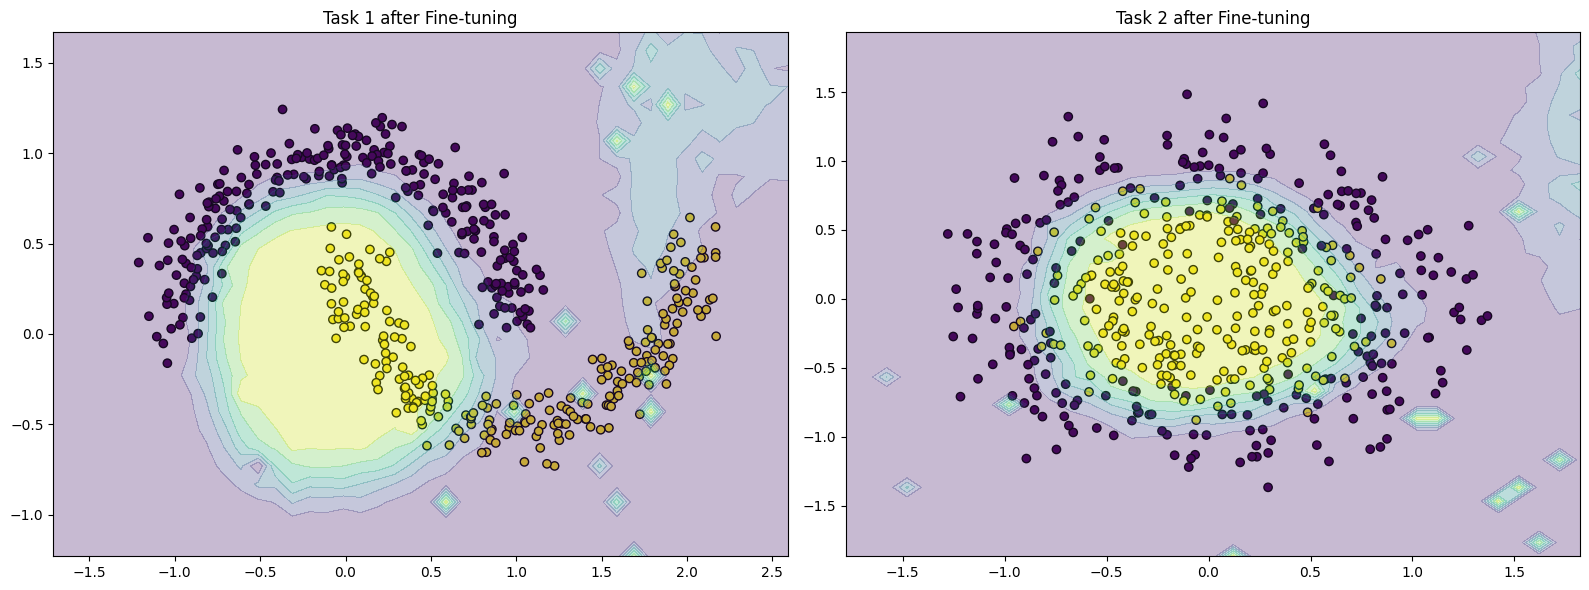

In [7]:
# Enable LoRA adapters (already enabled by default)
peft_model.enable_adapter_layers()

# Plot datasets with decision boundaries after fine-tuning
plot_datasets_and_boundaries(
    X_task1.numpy(),
    y_task1.numpy(),
    X_task2.numpy(),
    y_task2.numpy(),
    model=peft_model,
    titles=["Task 1 after Fine-tuning", "Task 2 after Fine-tuning"],
)

## Disable LoRA adapters to see the original model

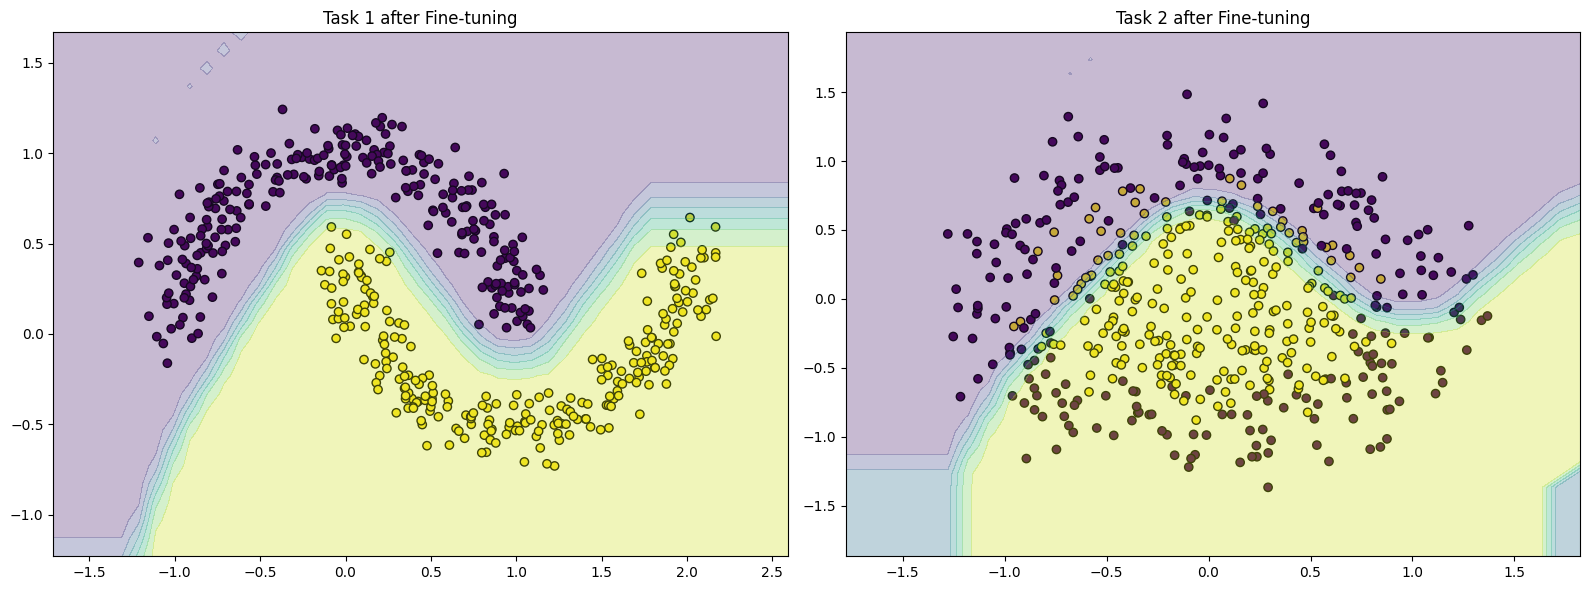

In [8]:
# Disable LoRA adapters
peft_model.disable_adapter_layers()

# Plot datasets with decision boundaries after fine-tuning
plot_datasets_and_boundaries(
    X_task1.numpy(),
    y_task1.numpy(),
    X_task2.numpy(),
    y_task2.numpy(),
    model=peft_model,
    titles=["Task 1 after Fine-tuning", "Task 2 after Fine-tuning"],
)

## Print statistics and save the model

In [9]:
# Enable LoRA adapters (already enabled by default)
peft_model.enable_adapter_layers()

# Print trainable (lora) parameters
peft_model.print_trainable_parameters()

# Save the model and remove all layers that will be done on the server
path = Path("lora_mlp")

if path.is_dir() and any(path.iterdir()):
    shutil.rmtree(path)

lora_trainer.save_and_clear_private_info(path)

# At this point, the client's model only contains the trainable parameters of the LoRA layers.
peft_model.print_trainable_parameters()

2025-02-28 12:19:40,251 - INFO - Model saved at lora_mlp


trainable params: 260 || all params: 902 || trainable%: 28.8248
trainable params: 260 || all params: 260 || trainable%: 100.0000


## Conclusion

This notebook demonstrates how Low-Rank Adaptation (LoRA) facilitates parameter-efficient fine-tuning of models on private data. By leveraging FHE, the training process ensures that sensitive data and private model updates remains secure.
 
**Key Takeaways:**
 
- **Efficiency with LoRA:** While this example utilizes an MLP model with a relatively high proportion of LoRA weights due to its simplicity, the approach scales effectively to larger models like large language models (LLMs). In such cases, LoRA typically accounts for **less than one percent** of the total model parameters, ensuring minimal memory and computational overhead on the client side.
- **Scalability and Practicality:** The hybrid approach demonstrated here is particularly beneficial for scenarios where client devices have limited resources. Memory heavy computations are offloaded to a secure server and the client handles only the lightweight LoRA adjustments locally.